In [4]:
import yfinance as yf
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

2025-03-03 15:54:24.890270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# fungsi load data saham apple(AAPL), preprocessing data, build model deep learning, training, evaluasi, prediksi masa depan
def load_stock_data(stock_simbol, start_date, end_date):
    df = yf.download(stock_simbol, start=start_date, end=end_date)
    return df['Close'].values.reshape(-1, 1)

def preprocess_data(data, sequence_length=60, train_split=0.9):
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    
    X, y = [], []
    for i in range(sequence_length, len(data_scaled)):
        X.append(data_scaled[i - sequence_length: i, 0])
        y.append(data_scaled[i, 0])
        
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1)) # format LSTM
    
    split_index = int(len(X) * train_split)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    
    return X_train, X_test, y_train, y_test, scaler, data_scaled

def build_lstm_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(units=128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(units=64, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(units=64, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(units=50, activation='relu'),
        tf.keras.layers.Dense(units=1)
    ])
    
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def train_model(X_train, y_train, X_test, y_test):
    model = build_lstm_model((X_train.shape[1], 1))
    model.summary()
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])
    return model

def predict_price(model, X_test, scaler):
    predicted_price = model.predict(X_test)
    predicted_price = scaler.inverse_transform(predicted_price.reshape(-1, 1))
    return predicted_price

def evaluate_model(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    print(f'mean absolute error (mae) : {mae:.3f}')
    print(f'mean squared error (mse) : {mse:.3f}')
    print(f'root mean squared error (rmse) : {rmse:.3f}')
    
def predict_future_price(model, data_scaled, scaler, sequence_length, future_days=300):
    future_predictions = []
    input_seq = np.array(data_scaled[-sequence_length:]).reshape(1, sequence_length, 1)
    
    for _ in range(future_days):
        next_pred = model.predict(input_seq)[0, 0]
        future_predictions.append(next_pred)
        next_pred_scaled = np.array([[next_pred]]).reshape(1, 1, 1)
        input_seq = np.append(input_seq[:, 1:, :], next_pred_scaled, axis=1)
    
    return scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [6]:
# fungsi visualisasi
# visualisasi prediksi
def visualize_predictions(actual_price, predicted_price, future_predictions):
    plt.figure(figsize=(12,6))
    sns.lineplot(x=range(len(actual_price)), y=actual_price.flatten(), label='harga aktual', color='blue')
    sns.lineplot(x=range(len(predicted_price)), y=predicted_price.flatten(), label='harga prediksi', color='red')
    future_x = range(len(actual_price), len(actual_price) + len(future_predictions))
    sns.lineplot(x=future_x, y=future_predictions.flatten(), label='prediksi masa depan', color='green')
    plt.fill_between(future_x, future_predictions.flatten() * 0.95, future_predictions.flatten() * 1, color='green', alpha=0.3)
    plt.legend()
    plt.xlabel('waktu')
    plt.ylabel('harga saham (usd)')
    plt.title('prediksi harga saham AAPL')
    plt.show()
    
# visualisasi candlestick
def visualize_candlestick(actual_price, predicted_price):
    plt.figure(figsize=(12,6))
    sns.barplot(x=range(len(actual_price)), y=actual_price.flatten(), color='blue', alpha=0.6, label='harga aktual')
    sns.barplot(x=range(len(predicted_price)), y=predicted_price.flatten(), color='red', alpha=0.6, label='harga prediksi')
    plt.legend()
    plt.xlabel('waktu')
    plt.ylabel('harga saham (usd)')
    plt.show()
    

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,301 (950.39 KB)

 Trainable params: 243,301 (950.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - loss: 0.0542 - val_loss: 0.0166
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - loss: 0.0090 - val_loss: 0.0063
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0049 - val_loss: 0.0070
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 0.0052 - val_loss: 0.0076
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
mean absolute error (mae) : 7.899
mean squared error (mse) : 83.297
root mean squared error (rmse) : 9.127
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 

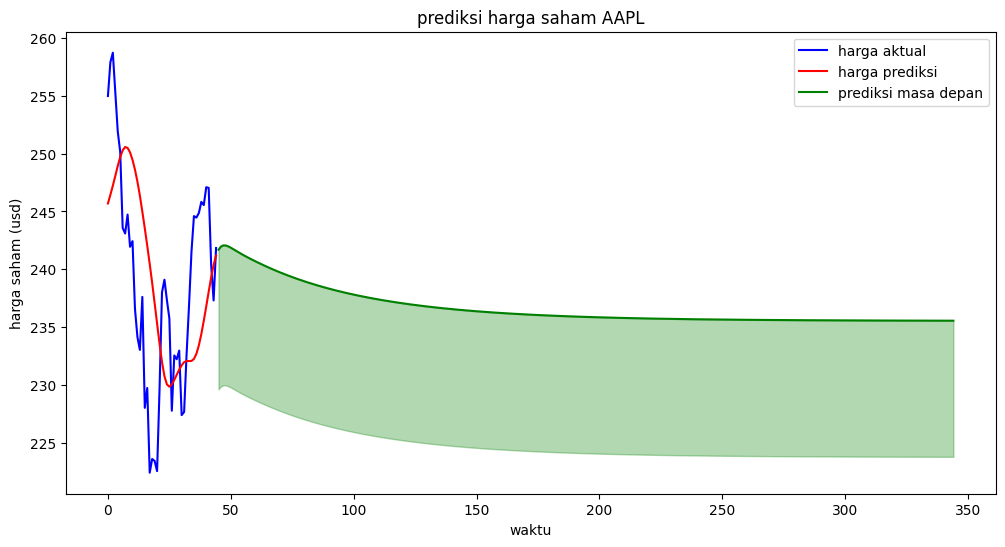

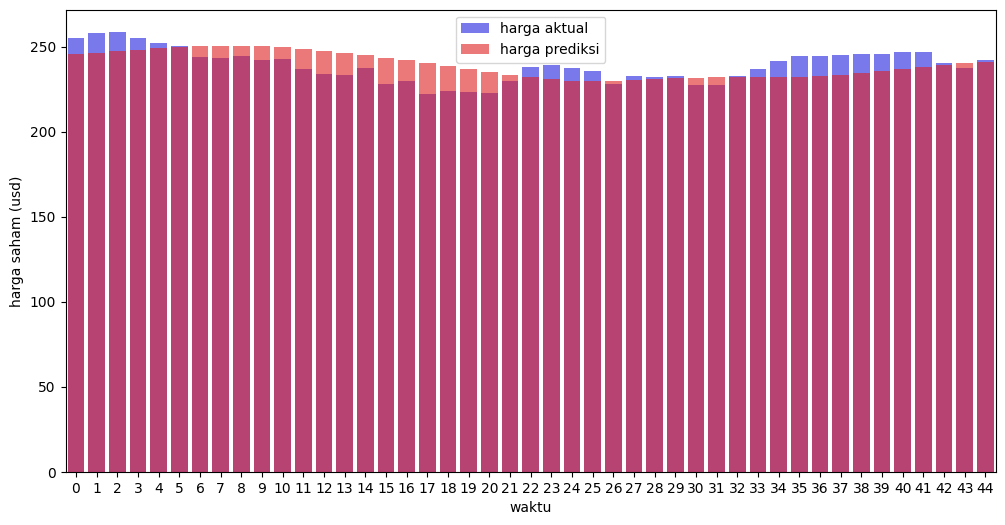

In [7]:
'''main program'''
# load dataset
stock_symbol = 'AAPL'
start_date = '2023-02-28'
end_date = '2025-03-03'
data = load_stock_data(stock_symbol, start_date, end_date)

# preprocess dataset
sequence_length = 60
X_train, X_test, y_train, y_test, scaler, data_scaled = preprocess_data(data, sequence_length)

# training model
model = train_model(X_train, y_train, X_test, y_test)

# prediksi harga
predicted_price = predict_price(model, X_test, scaler)
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))

# evaluasi model
evaluate_model(actual_price, predicted_price)

# predicted future price
future_predictions = predict_future_price(model, data_scaled, scaler, sequence_length)

# visualisasi
visualize_predictions(actual_price, predicted_price, future_predictions)
visualize_candlestick(actual_price, predicted_price)
